In [223]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn import metrics
import math
from pyswarm import pso
import warnings
warnings.filterwarnings("ignore")

In [160]:
df = pd.read_csv('oilseed data set.csv')
timeseries = df['Production'].values
timeseries

array([ 5.16,  5.03,  4.73,  5.37,  6.4 ,  5.73,  6.36,  6.35,  7.3 ,
        6.56,  6.98,  7.28,  7.39,  7.13,  8.56,  6.4 ,  6.43,  8.3 ,
        6.85,  7.73,  9.63,  9.08,  7.14,  9.39,  9.15, 10.61,  8.43,
        9.66, 10.1 ,  8.74,  9.37, 12.08, 10.  , 12.69, 12.95, 10.83,
       11.27, 12.65, 18.03, 16.92, 18.61, 18.6 , 20.11, 21.5 , 21.34,
       22.11, 24.38, 21.32, 24.75, 20.71, 18.44, 20.66, 14.84, 25.19,
       24.35, 27.98, 24.29, 29.76, 27.72, 24.88, 32.48, 29.8 , 30.94,
       32.75, 26.67, 25.25, 31.28, 31.46, 31.52, 33.42, 36.56, 37.15])

array([[<AxesSubplot: title={'center': 'Production'}>]], dtype=object)

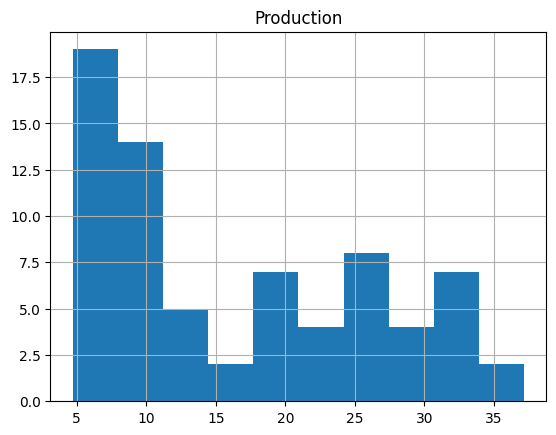

In [161]:
df.hist('Production')

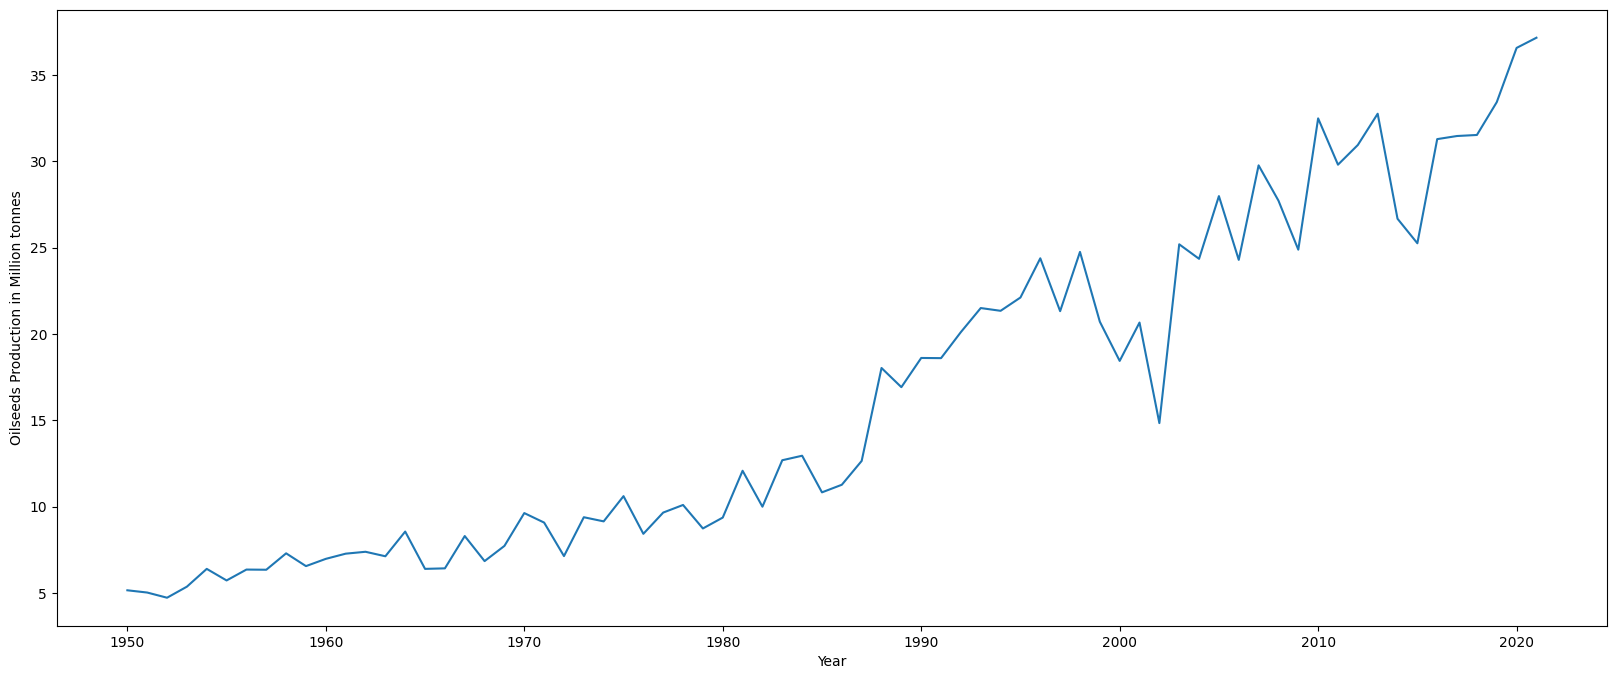

In [162]:
plt.figure(figsize=(20,8))
plt.plot(df['Year'],df['Production'])
plt.xlabel('Year')
plt.ylabel('Oilseeds Production in Million tonnes')
plt.show()

In [163]:
train = df.iloc[0:62,1]
test = df.iloc[62:len(df),1]
print("Train Shape : ",train.shape)
print("Test Shape : ",test.shape)

Train Shape :  (62,)
Test Shape :  (10,)


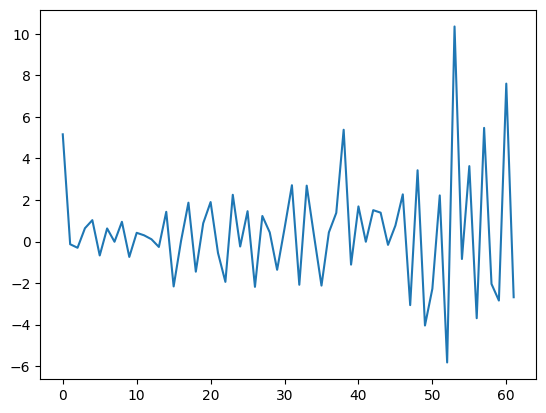

In [164]:
df_d = train.diff().fillna(train)
plt.plot(df_d)
plt.show()

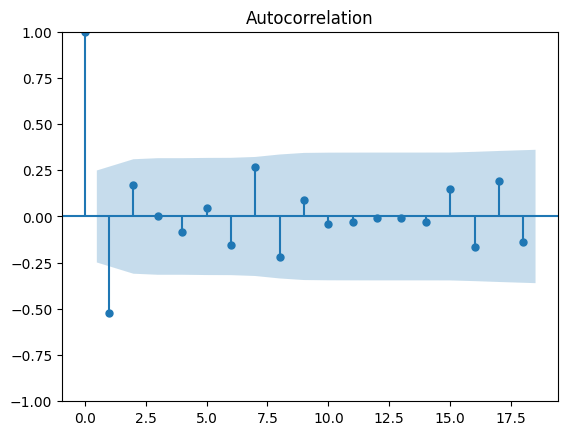

In [165]:
plot_acf(df_d)
plt.show()

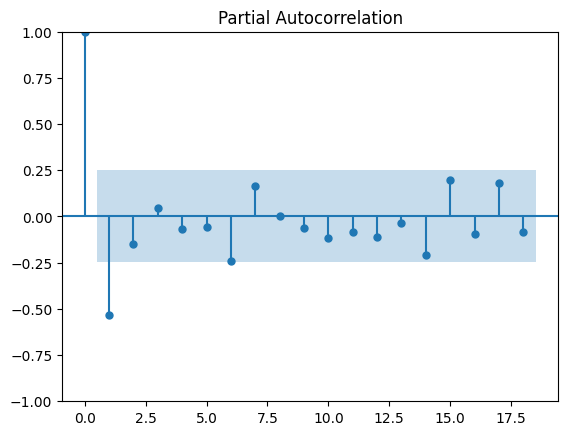

In [224]:
plot_pacf(df_d)
plt.show()

In [167]:
model1 = ARIMA(train, order= (1,1,0))
model_fit1 = model1.fit()
model_fit1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             Production   No. Observations:                   62
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -137.257
Date:                Thu, 22 Dec 2022   AIC                            278.513
Time:                        00:50:16   BIC                            282.735
Sample:                             0   HQIC                           280.168
                                 - 62                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5062      0.075     -6.732      0.000      -0.654      -0.359
sigma2         5.2461      0.736      7.126      0.000       3.803       6.689
===================================================================================
Ljung-Box (L1) (Q):                   0.86   Jarque-Bera (JB):                 7.67
Prob(Q):                              0.35   Prob(JB):                         0.02
Heteroskedasticity (H):              12.51   Skew:                             0.43
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [168]:
start = 63
end = 72
yhat = model_fit1.predict(start = start, end = end, typ = 'levels')
print(yhat)

63    30.469897
64    30.817490
65    30.641543
66    30.730605
67    30.685523
68    30.708343
69    30.696792
70    30.702639
71    30.699679
72    30.701177
Name: predicted_mean, dtype: float64


In [169]:
MSE = metrics.mean_squared_error(test,yhat)
RMSE = math.sqrt(MSE)
MAE = metrics.mean_absolute_error(test,yhat)
print("MSE: ",MSE)
print("MAE: ",MAE)
print("RMSE: ",RMSE)

MSE:  13.467656213287373
MAE:  2.9050606527735723
RMSE:  3.669830542857173


In [218]:
def objective_function(parameters):
    # unpack the parameters
    p, d, q = parameters
    # make sure that the parameters are integers
    p = 1
    d = 1
    q = 0
    # try fitting an ARIMA model with the given parameters
    try:
        model = ARIMA(df['Production'].values, order=(p, d, q))
        model_fit = model.fit(disp=False)
    except:
        # if the model cannot be fit, return a large error
        return np.inf
    # return the AIC of the fitted model
    return model_fit.aic

# define the lower and upper bounds for the p, d, and q parameters
lower_bounds = np.array([0, 1, 0])
upper_bounds = np.array([5, 1, 5])

# number of particles in the swarm
num_particles = 10
# number of dimensions (p, d, q)
num_dimensions = 3
# maximum velocity
max_velocity = 0.2 * (upper_bounds - lower_bounds)
# maximum acceleration
max_acceleration = 0.2 * max_velocity
# maximum number of iterations
max_iterations = 100

# initialize the positions and velocities of the particles
positions = lower_bounds + (upper_bounds - lower_bounds) * np.random.rand(num_particles, num_dimensions)
velocities = -max_velocity + 2 * max_velocity * np.random.rand(num_particles, num_dimensions)

# initialize the best known positions and values for each particle
best_positions = positions.copy()
best_values = np.array([objective_function(pos) for pos in positions])

# initialize the best known position and value overall
global_best_position = best_positions[np.argmin(best_values)]
global_best_value = np.min(best_values)

In [219]:
for iteration in range(max_iterations):
    # update the velocities of the particles
    velocities = velocities + max_acceleration * np.random.rand(num_particles, num_dimensions)
    velocities = np.clip(velocities, -max_velocity, max_velocity)
    # update the positions of the particles
    positions = positions + velocities
    # keep the positions within the bounds
    positions = np.clip(positions, lower_bounds, upper_bounds)
    # evaluate the objective function at the new positions
    values = np.array([objective_function(pos) for pos in positions])
    # update the best known positions and values for each particle
    update_idx = values < best_values
    best_values[update_idx] = values[update_idx]
    best_positions[update_idx] = positions[update_idx]
    # update the best known position and value overall
    if np.min(best_values) < global_best_value:
        global_best_value = np.min(best_values)
        global_best_position = best_positions[np.argmin(best_values)]

# print the optimal parameters and the corresponding loss (AIC)
print("Optimal parameters:", global_best_position)
print("Loss (AIC):", global_best_value)

Optimal parameters: [4.49566366 1.         3.631047  ]
Loss (AIC): inf


In [225]:
model1 = ARIMA(train, order= (4,1,3))
model_fit1 = model1.fit()
model_fit1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             Production   No. Observations:                   62
Model:                 ARIMA(4, 1, 3)   Log Likelihood                -132.759
Date:                Thu, 22 Dec 2022   AIC                            281.518
Time:                        01:28:53   BIC                            298.405
Sample:                             0   HQIC                           288.136
                                 - 62                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3084      0.159     -1.937      0.053      -0.621       0.004
ar.L2          0.2834      0.202      1.405      0.160      -0.112       0.679
ar.L3         -0.6857      0.194     -3.526      0.000      -1.067      -0.305
ar.L4         -0.5947      0.123     -4.835      0.000      -0.836      -0.354
ma.L1         -0.1604    140.856     -0.001      0.999    -276.234     275.913
ma.L2         -0.1704    163.513     -0.001      0.999    -320.651     320.310
ma.L3          0.9900    139.778      0.007      0.994    -272.970     274.950
sigma2         4.1557    586.012      0.007      0.994   -1144.407    1152.719
===================================================================================
Ljung-Box (L1) (Q):                   0.54   Jarque-Bera (JB):                 2.73
Prob(Q):                              0.46   Prob(JB):                         0.25
Heteroskedasticity (H):              10.08   Skew:                             0.46
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.48
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [226]:
start = 63
end = 72
yhat = model_fit1.predict(start = start, end = end, typ = 'levels')
print(yhat)

63    31.313835
64    32.662836
65    30.527111
66    30.881770
67    30.638175
68    31.476176
69    32.175482
70    32.153405
71    31.928586
72    31.013813
Name: predicted_mean, dtype: float64


In [227]:
MSE = metrics.mean_squared_error(test,yhat)
RMSE = math.sqrt(MSE)
MAE = metrics.mean_absolute_error(test,yhat)
print("MSE: ",MSE)
print("MAE: ",MAE)
print("RMSE: ",RMSE)

MSE:  10.829039242306155
MAE:  2.329755960977301
RMSE:  3.290750559113552


In [177]:
model2 = ARIMA(df['Production'], order= (2,1,4))
model_fit2 = model2.fit()
model_fit2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             Production   No. Observations:                   72
Model:                 ARIMA(2, 1, 4)   Log Likelihood                -162.788
Date:                Thu, 22 Dec 2022   AIC                            339.576
Time:                        00:51:38   BIC                            355.415
Sample:                             0   HQIC                           345.875
                                 - 72                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6165      1.670     -0.369      0.712      -3.889       2.656
ar.L2          0.1557      1.399      0.111      0.911      -2.586       2.897
ma.L1          0.2079      1.697      0.123      0.902      -3.118       3.534
ma.L2         -0.2903      0.785     -0.370      0.711      -1.828       1.247
ma.L3          0.2653      0.401      0.661      0.509      -0.521       1.052
ma.L4         -0.1360      0.417     -0.326      0.744      -0.953       0.681
sigma2         5.6839      0.958      5.930      0.000       3.805       7.562
===================================================================================
Ljung-Box (L1) (Q):                   0.42   Jarque-Bera (JB):                 2.49
Prob(Q):                              0.51   Prob(JB):                         0.29
Heteroskedasticity (H):              13.29   Skew:                             0.19
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [151]:
start = 1
end = 75
yhat2 = model_fit2.predict(start = start, end = end, typ = 'levels')
print(yhat2)

1      5.159984
2      5.084545
3      4.881186
4      5.072920
5      5.899071
        ...    
71    34.655722
72    37.171199
73    37.265997
74    37.393115
75    36.990365
Name: predicted_mean, Length: 75, dtype: float64


In [228]:
year = df['Year'] 

year = pd.DataFrame(year)
dict = {'Year':['2022','2023','2024']}
year2 = pd.DataFrame(dict)
yhat2 = pd.DataFrame(yhat2)
yhat2 = yhat2.reset_index()
yhat2 = yhat2.drop('index',1)
df3 = pd.concat([year, year2], ignore_index = True)
df3 = df3.reset_index()
df3['Year'] = df3['Year'].astype('int')
df3['Actual'] = df['Production']
df3['Predictions'] = yhat2
df3['Predictions'] = df3['Predictions'].astype(float)
df3 = df3.fillna('')
df3

,index,Year,Actual,Predictions
0,0,1950,5.16,5.159984
1,1,1951,5.03,5.084545
2,2,1952,4.73,4.881186
3,3,1953,5.37,5.072920
4,4,1954,6.4,5.899071
...,...,...,...,...
70,70,2020,36.56,34.655722
71,71,2021,37.15,37.171199
72,72,2022,,37.265997
73,73,2023,,37.393115


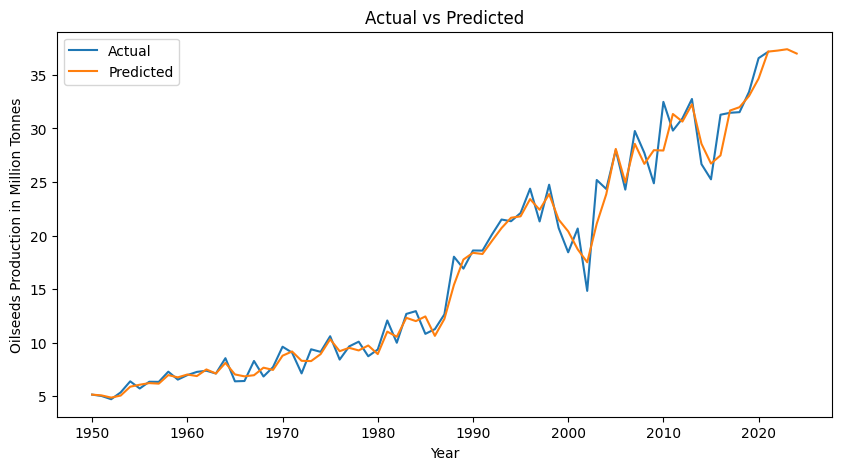

In [153]:
plt.figure(figsize=(10,5))
plt.plot(df['Year'], df['Production'], label = "Actual")
plt.plot(df3['Year'], df3['Predictions'], label = "Predicted")
plt.xlabel('Year')
plt.ylabel('Oilseeds Production in Million Tonnes')
plt.title('Actual vs Predicted')
plt.legend()
plt.show()